In [17]:
import sklearn
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import pickle
import os
import joblib
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')

In [18]:
conn = sqlite3.connect('../db.sqlite3')
df_raw = pd.read_sql_query('''
SELECT "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine" 
FROM scraper_auto  
WHERE prijs < 15000
''', conn)
df = df_raw.dropna()
df.describe()

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine
count,1201.00000,1.201000e+03,1201.000000,1201.000000,1201.000000,1201.000000
mean,2009.80433,1.673047e+05,83.735221,3655.383014,0.976686,0.574521
std,2.88863,9.653735e+04,13.467795,2278.789858,0.150961,0.494621
min,2005.00000,7.183000e+03,51.000000,1.000000,0.000000,0.000000
25%,2007.00000,1.181140e+05,77.000000,2295.000000,1.000000,0.000000
50%,2010.00000,1.710000e+05,84.000000,2950.000000,1.000000,1.000000
75%,2011.00000,2.100000e+05,86.000000,4240.000000,1.000000,1.000000
max,2018.00000,2.625966e+06,180.000000,13900.000000,1.000000,1.000000


In [23]:
df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]['prijs']

In [24]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, ['bouwjaar', "kilometer_stand", "vermogen"]),
    ],
    remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Epoch 1/500
30/30 [==============================] - 0s 10ms/step - loss: 18339208.0000 - mae: 3626.0549 - mse: 18339208.0000 - val_loss: 19158724.0000 - val_mae: 3744.4941 - val_mse: 19158724.0000
Epoch 2/500
30/30 [==============================] - 0s 3ms/step - loss: 18130036.0000 - mae: 3602.2026 - mse: 18130036.0000 - val_loss: 18716924.0000 - val_mae: 3696.3860 - val_mse: 18716924.0000
Epoch 3/500
30/30 [==============================] - 0s 3ms/step - loss: 17373210.0000 - mae: 3517.9700 - mse: 17373210.0000 - val_loss: 17373632.0000 - val_mae: 3549.1702 - val_mse: 17373632.0000
Epoch 4/500
30/30 [==============================] - 0s 3ms/step - loss: 15531552.0000 - mae: 3305.3782 - mse: 15531552.0000 - val_loss: 14510298.0000 - val_mae: 3219.9622 - val_mse: 14510298.0000
Epoch 5/500
30/30 [==============================] - 0s 3ms/step - loss: 12200006.0000 - mae: 2893.7551 - mse: 12200006.0000 - val_loss: 10191717.0000 - val_mae: 2652.4663 - val_mse: 10191717.0000
Epoch 6/500
30

(0.0, 47.0)

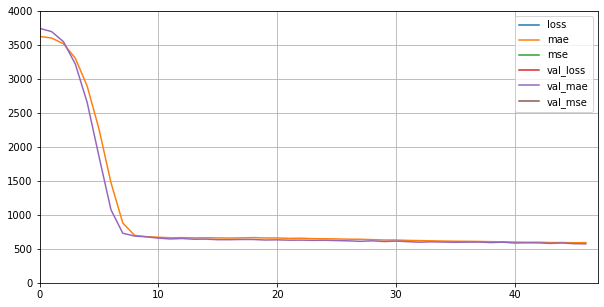

In [27]:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", input_shape=X_train.shape[1:]),
#     keras.layers.Dense(200, activation="relu"),
#     keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(
    loss="mean_squared_error", 
    optimizer=optimizer, 
    metrics=['mae', 'mse']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

history = model.fit(
    X_train, 
    y_train.values, 
    batch_size=32, 
    epochs=500, 
    validation_data=(X_test, y_test.values),
    verbose=1,
    callbacks=[callback]
)

mse_test = model.evaluate(X_test, y_test.values)

pd.DataFrame(history.history).plot(figsize=(10, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 4000) 
plt.gca().set_xlim(0, len(history.history['loss'])) 

In [28]:
model_path = os.path.join("NeuralNetwork") 
model.save(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Network\assets
